## Import Relevant packages

In [1]:
import pandas as pd
import numpy as np

# For Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter

# For Data Preparation
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.tree import plot_tree
import re

# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

# For Evaluation of Results
from sklearn.metrics import f1_score
from sklearn import metrics

# For Product
from IPython.display import HTML
from termcolor import colored
from pyfiglet import Figlet

pd.options.mode.chained_assignment = None

## Importing of Dataset

Our dataset has 5 columns:

'v1': States whether the message is 'ham' (non-spam) or 'spam'

'v2': The content of the message

'Unnamed: 2': Contains some text, most of the cells are empty

'Unnamed: 3': Contains some text, most of the cells are empty

'Unnamed: 4': Contains some text, most of the cells are empty


Let's explore the dataset and do some preliminary cleaning.

In [2]:
df = pd.read_csv('spam.csv', encoding='iso-8859-1')
df.shape

(5572, 5)

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


At first glance, it's unclear what the 'Unnamed' columns are for. Let's take a look.

In [5]:
unnamed = df[df['Unnamed: 2'].isnull()==False]
unnamed.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


After looking at the original file, we found that these columns are actually a continuation of the main message. They were separated into different columns by the commas within the message itself. We will combine the last four columns together and rename them for better readability.

In [6]:
df['full_message'] = df['v2'].fillna('') + ' ' + df['Unnamed: 2'].fillna('')+ ' ' + df['Unnamed: 3'].fillna('')+ ' ' + df['Unnamed: 4'].fillna('')

df.rename(columns={'v1':'Category', 'full_message':'Message'}, inplace = True)
df = df.drop(['v2', 'Unnamed: 2', 'Unnamed: 3','Unnamed: 4'], axis=1)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.shape #new dimensions

(5572, 2)

In [8]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


It seems that not all of the messages are unique, which means that there are some duplicates. We will explore these later.

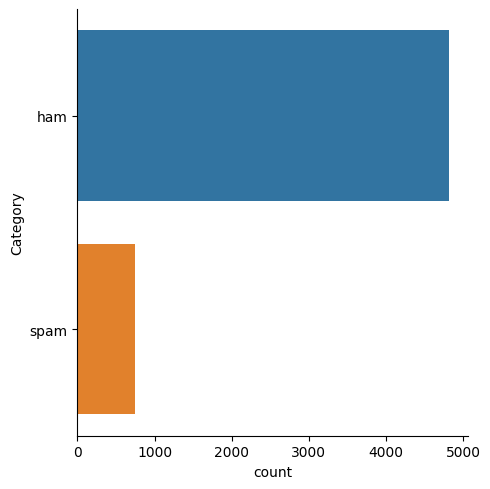

In [9]:
sns.catplot(y='Category', data=df, kind='count')

In [10]:
countY, countX = df.Category.value_counts()
print("The ratio of non-spam to spam is %.2f: 1" % (countY/countX))

The ratio of non-spam to spam is 6.46: 1


As you can see, the data is quite imbalanced between non-spam and spam messages, which may affect the accuracy of any machine learning models we will use to predict the type of message. We will do some more data cleaning and then do exploratory data analysis.

## Data Cleaning

#### Changing of 'ham' and 'spam' to 0 and 1 respectively

In [11]:
df.loc[df.Category == 'ham', 'Category'] = 0
df.loc[df.Category == 'spam', 'Category'] = 1
print(df.Category.value_counts())

0    4825
1     747
Name: Category, dtype: int64


#### Removal of duplicates in SMS Messages

In [12]:
df.duplicated(subset=['Message']).value_counts()

False    5169
True      403
dtype: int64

As seen, there are 403 duplicates in the dataset and have to be removed in order to prevent skewing the data.


In [13]:
df = df.drop_duplicates(subset=['Message'], keep = 'last')
df.reset_index(drop=True, inplace=True)

print(df.shape)
print(df["Category"].value_counts())

(5169, 2)
0    4516
1     653
Name: Category, dtype: int64


In [14]:
df.describe()

,Category,Message
count,5169,5169
unique,2,5169
top,0,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


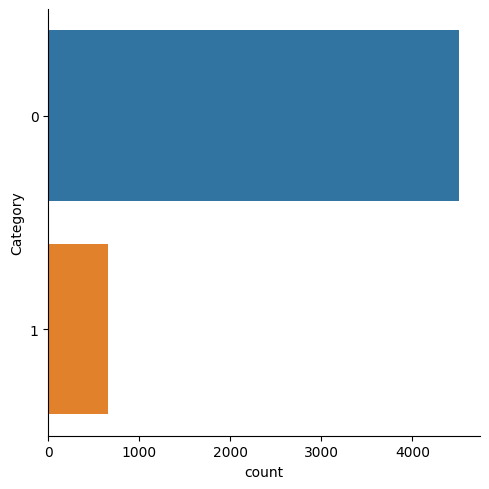

In [15]:
sns.catplot(y='Category', data=df, kind='count') #new catplot after removing the duplicates

In [16]:
countY, countX = df.Category.value_counts()
print("The ratio of non-spam to spam is %.2f: 1" % (countY/countX))

The ratio of non-spam to spam is 6.92: 1


The ratio of non-spam to spam is even higher now. This means that a majority of the duplicated messages that were removed were spam. Makes sense, since the same spam message is often sent to many people at once.

## Data Preparation

Generating Stop Words

In [17]:
stopwords = list(ENGLISH_STOP_WORDS) + list(STOPWORDS) + ['u']
print(stopwords)

['also', 'seeming', 'whom', 'we', 'should', 'mine', 'something', 'have', 'my', 'whereby', 'by', 'find', 'onto', 'hundred', 'besides', 'however', 'who', 'here', 'his', 'less', 'throughout', 'about', 'itself', 'do', 'must', 'often', 'across', 'six', 'already', 'him', 'fire', 'so', 'there', 'how', 'almost', 'had', 'anything', 'down', 'the', 'only', 'formerly', 'enough', 'whether', 'became', 'around', 'detail', 'hasnt', 'out', 'de', 'that', 'serious', 'see', 'nevertheless', 'against', 'whence', 'fifty', 'with', 'part', 'anyone', 'amount', 'former', 'from', 'cant', 'un', 'nothing', 'eg', 'afterwards', 'neither', 'otherwise', 'above', 'whither', 'over', 'nowhere', 'full', 'next', 'ours', 'ltd', 'could', 'further', 'bill', 'become', 'are', 'sincere', 'together', 'anyway', 'under', 'thereupon', 'not', 'elsewhere', 'than', 'thence', 'get', 'they', 'whenever', 'in', 'well', 'thick', 'too', 'whatever', 'noone', 'name', 'first', 'three', 'on', 'then', 'twelve', 'therefore', 'every', 'perhaps', 'tw


#### Phone Number Detection

Spam messages often contain a link or phone number which lures victims into giving away their private information. Let's see if this is reflected in our dataset.

Looking through the data, there are many instances when phone numbers were present in the message and the message was classified as spam.

In [18]:
pattern = r'\d{6,}' ## Detect messages containing a string of >=6 continuous numbers

## Create a new column to store the results of the pattern match
df['Contain_HP'] = df['Message'].apply(lambda x: bool(re.search(pattern, x)))

df.head(10)

,Category,Message,Contain_HP
0,0,"Go until jurong point, crazy.. Available only ...",False
1,0,Ok lar... Joking wif u oni...,False
2,0,U dun say so early hor... U c already then say...,False
3,0,"Nah I don't think he goes to usf, he lives aro...",False
4,1,FreeMsg Hey there darling it's been 3 week's n...,False
5,0,Even my brother is not like to speak with me. ...,False
6,0,I'm gonna be home soon and i don't want to tal...,False
7,0,I've been searching for the right words to tha...,False
8,0,I HAVE A DATE ON SUNDAY WITH WILL!!,False
9,1,"XXXMobileMovieClub: To use your credit, click ...",False


In [19]:
df['Contain_HP'].value_counts()

False    4801
True      368
Name: Contain_HP, dtype: int64

# Exploratory Data Analysis and Visualisation

#### Phone Number Barchart

Category  Contain_HP
0         False         4513
1         True           365
          False          288
0         True             3
dtype: int64


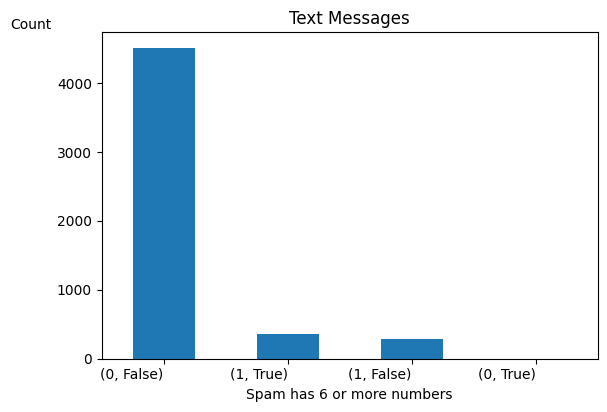

In [20]:
fig, ax = plt.subplots()
df[['Category', 'Contain_HP']].value_counts().plot(kind='bar', ax=ax)

# Set the axis labels and title
ax.set_xlabel('Spam has 6 or more numbers')
ax.set_ylabel('Count', loc = 'top', rotation = 0)
ax.set_title('Text Messages')
fig.autofmt_xdate(rotation=0)
print(df[['Category', 'Contain_HP']].value_counts())
# Show the plot
plt.show()

For each of the columns in the bar chart:

0 represents ham messages, while 1 represents spam messages.

'False' represents messages that did not contain a string of 6 or more numbers, while 'True' represents messages that contained a string of 6 or more numbers.

So (0, False) stands for messages that were classified as not spam and did not contain any phone numbers.

As we can see, the bar chart showed that most of the messages that did not contain phone numbers were not spam messages. So having a phone number in the message could be a good indicator of whether it is spam or not.

#### Comparing word count of spam and ham messages

In [21]:
# Change all string to lowercase
spam_messages = df[df['Category'] == 1]['Message'].str.lower()
ham_messages = df[df['Category'] == 0]['Message'].str.lower()

# Genertate List of message lengths
spam_lengths = [len(x) for x in spam_messages]
ham_lengths = [len(x) for x in ham_messages]

# Describe Data
spam = pd.DataFrame({'Spam':spam_lengths})
print(spam.describe())
ham = pd.DataFrame({'Ham':ham_lengths})
print(ham.describe())

             Spam
count  653.000000
mean   141.163859
std     29.915050
min     16.000000
25%    135.000000
50%    152.000000
75%    160.000000
max    227.000000
               Ham
count  4516.000000
mean     74.049159
std      56.695775
min       5.000000
25%      37.000000
50%      56.000000
75%      95.000000
max     913.000000


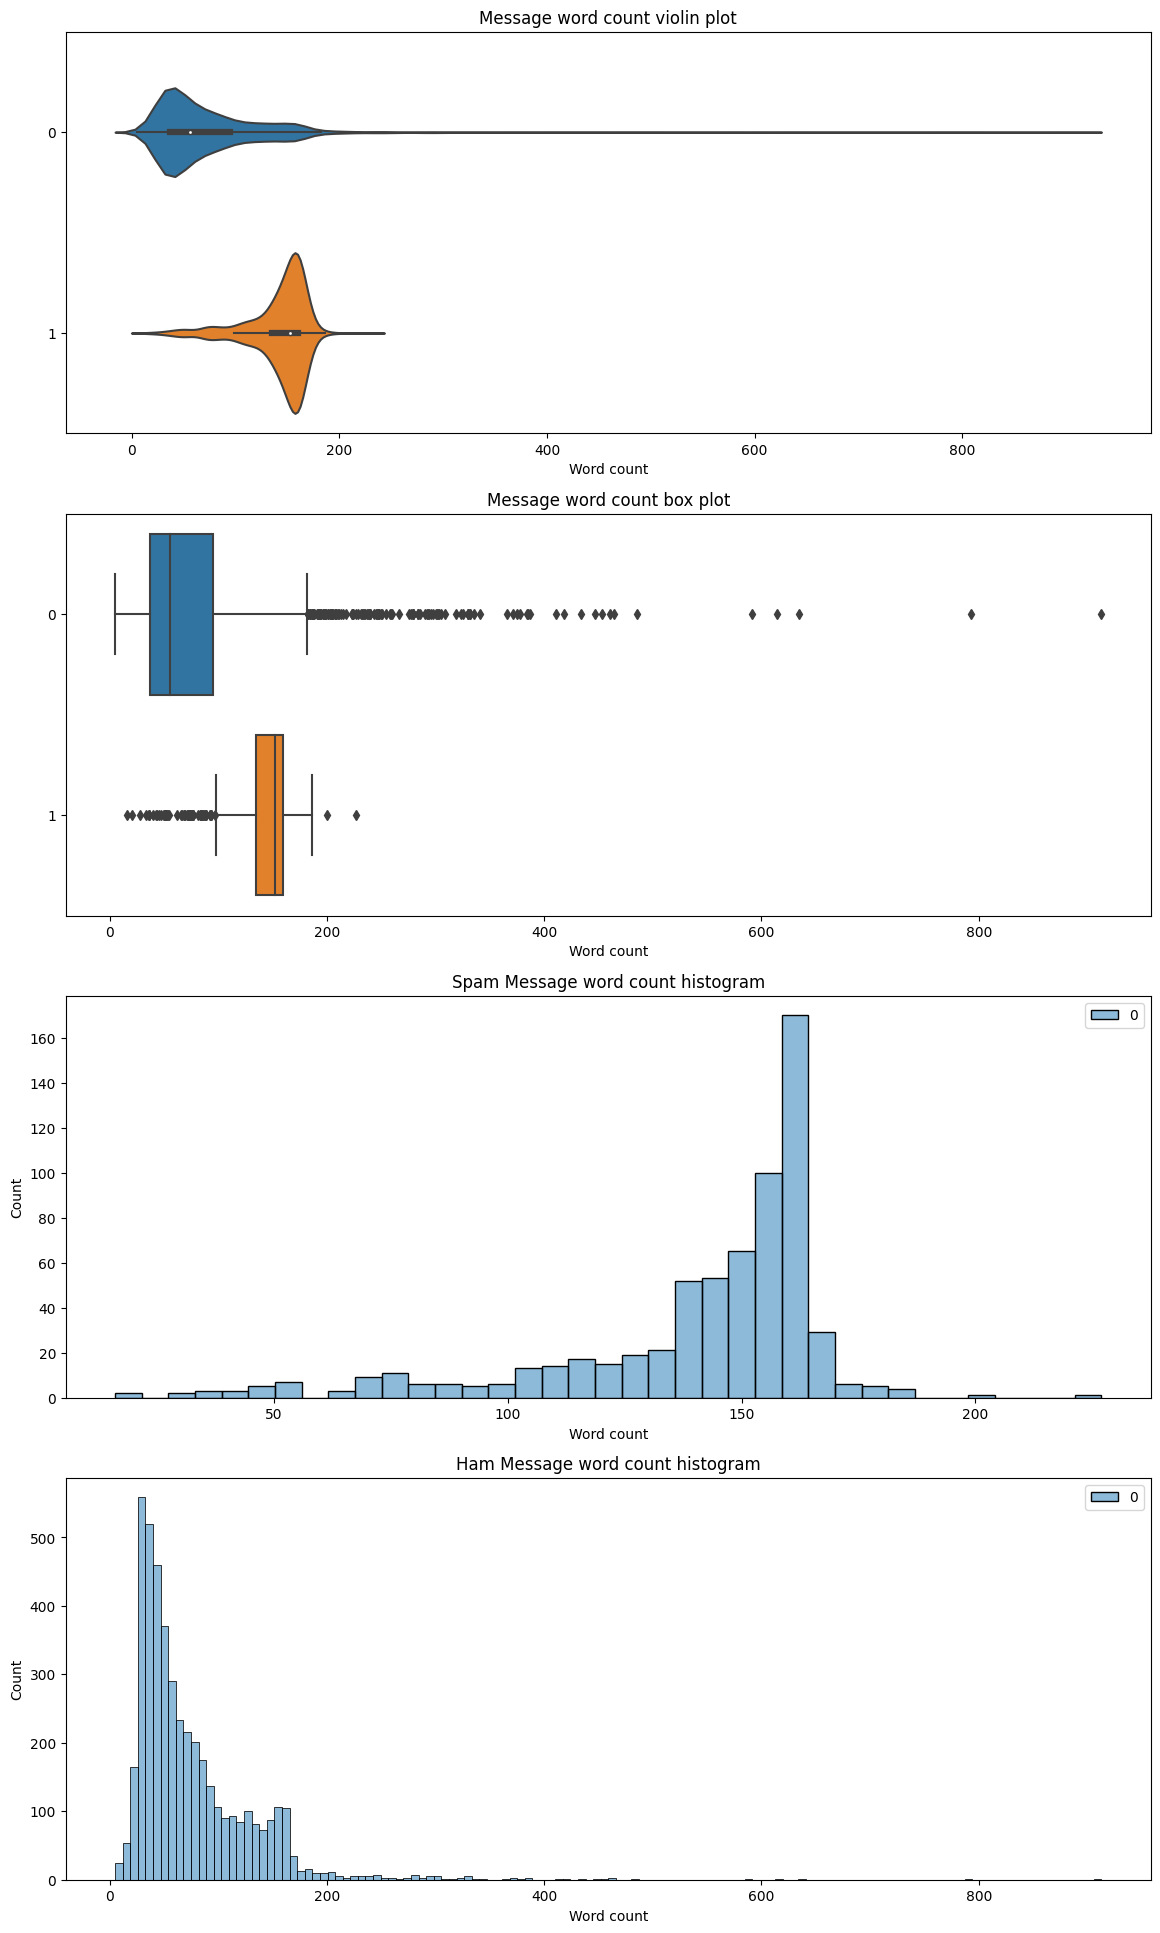

In [22]:
f, axes = plt.subplots(4, 1, figsize=(14, 24))


sns.violinplot(data=[ham_lengths, spam_lengths], ax=axes[0], orient = "h").set(
    title="Message word count violin plot", 
    xlabel='Word count') ## Plot two violin plots using Seaborn
sns.boxplot(data=[ham_lengths, spam_lengths], ax=axes[1], orient = "h").set(
    title="Message word count box plot", 
    xlabel='Word count') ## Plot two box plots using Seaborn
sns.histplot(data=[spam_lengths], ax=axes[2]).set(
    title="Spam Message word count histogram", 
    xlabel='Word count') ## Plot Spam Histogram plots using Seaborn
sns.histplot(data=[ham_lengths], ax=axes[3]).set(
    title="Ham Message word count histogram", 
    xlabel='Word count') ## Plot Ham Histogram plots using Seaborn

# Show the plot
plt.show()

The median of the word count for spam messages is higher than that of ham messages, and the range of values for word count of spam messages is much wider. Additionally, the plots show that the word count for ham is skewed towards the left, while for spam it is skewed towards the right. So word count could also determine the type of message.

#### Top 20 Most Frequent Words

Let's look at the most frequent words in all of the messages.

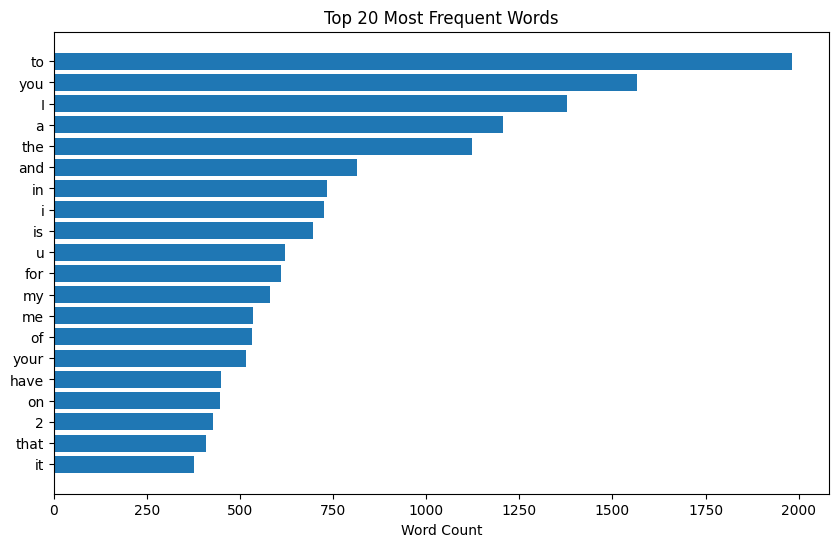

In [23]:
# Generate List of 20 Most common words
words = Counter(' '.join(df['Message']).split()).most_common(20)

#Plotting horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(words))
ax.barh(y_pos, [count for word, count in words])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in words])
ax.invert_yaxis()
ax.set_xlabel('Word Count')
ax.set_title('Top 20 Most Frequent Words')
plt.show()

#### Word Cloud for Spam Messages

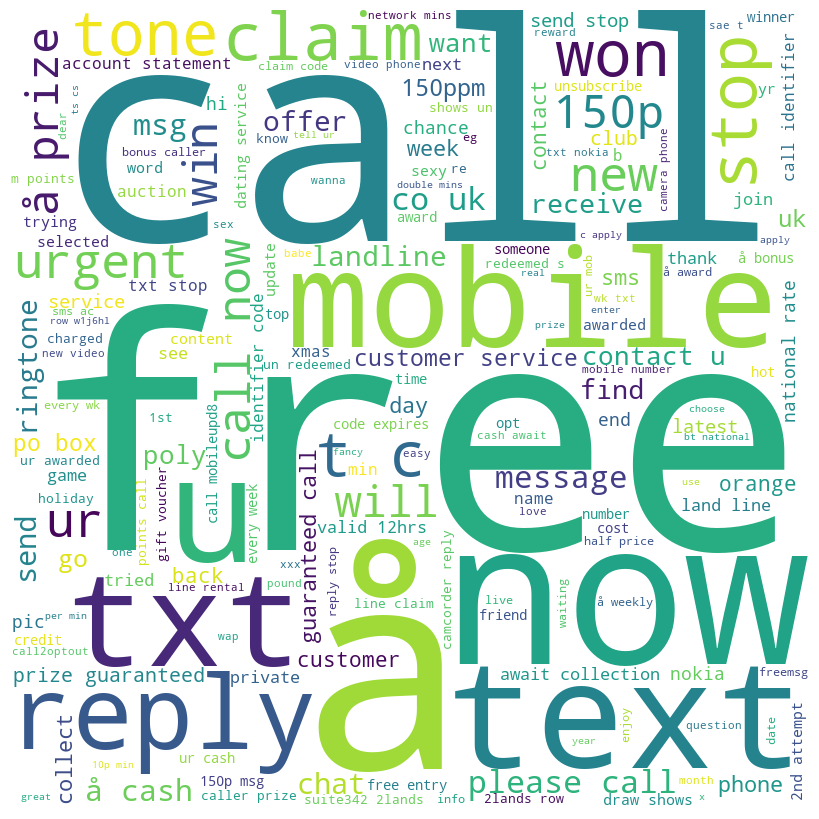

In [24]:
# Concatenate all spam messages into a single string
spam_text = ' '.join(spam_messages)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white',min_font_size=10).generate(spam_text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Next, let's see if the most common words in spam messages are different from those in ham messages.

#### Bar graph for 20 most common words in Spam Messages

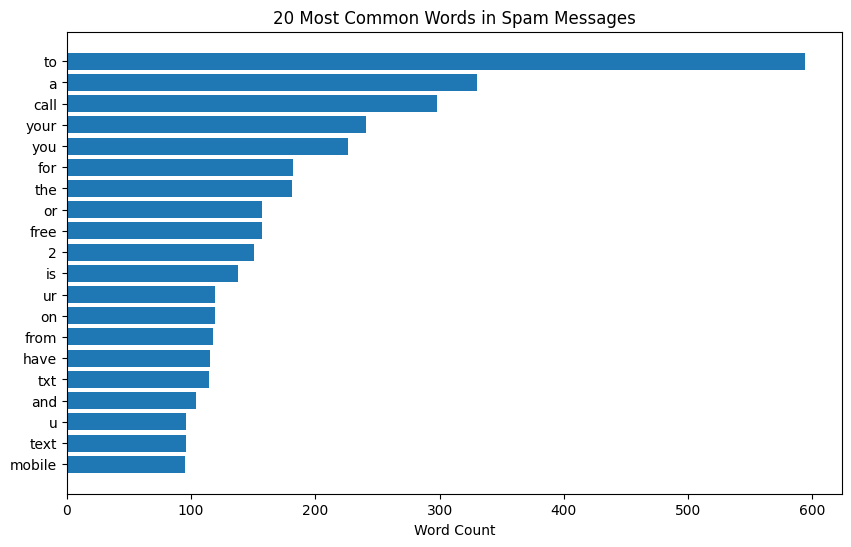

In [25]:
spam_messages = df[df['Category'] == 1]['Message']
spam_words = Counter([word for message in spam_messages for word in message.lower().split()]).most_common(20)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(spam_words))
ax.barh(y_pos, [count for word, count in spam_words])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in spam_words])
ax.invert_yaxis()  # invert the y-axis to show most frequent words on top
ax.set_xlabel('Word Count')
ax.set_title('20 Most Common Words in Spam Messages')
plt.show()

#### Word Cloud for Non-Spam Messages

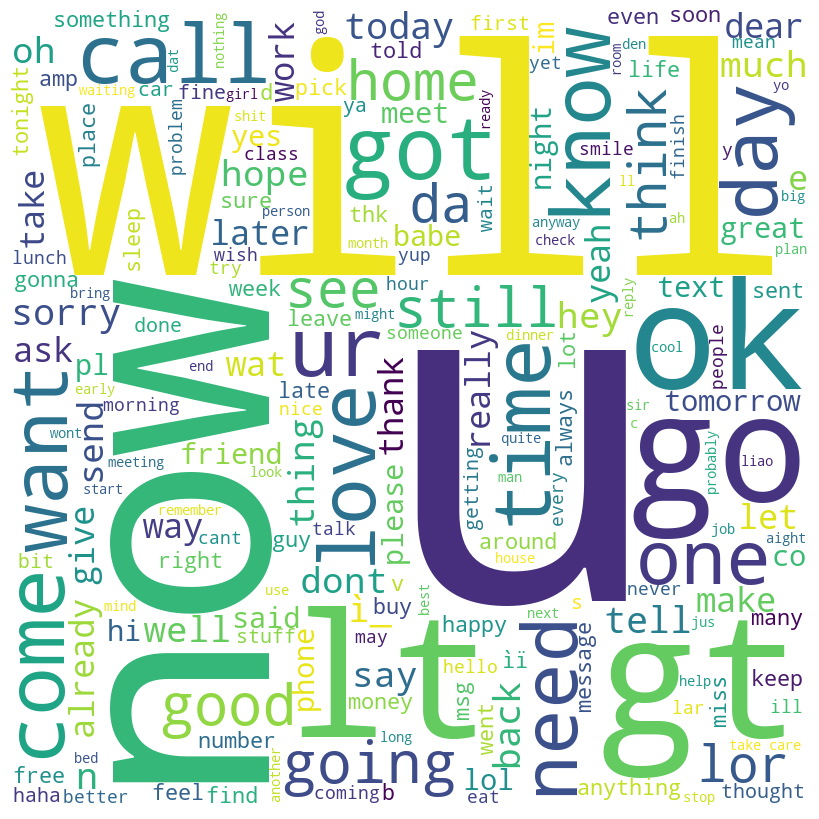

In [26]:
# Concatenate all non-spam messages into a single string
nonspam_text = ' '.join(ham_messages)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(nonspam_text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Bar graph for 20 most common words in Non-Spam Messages

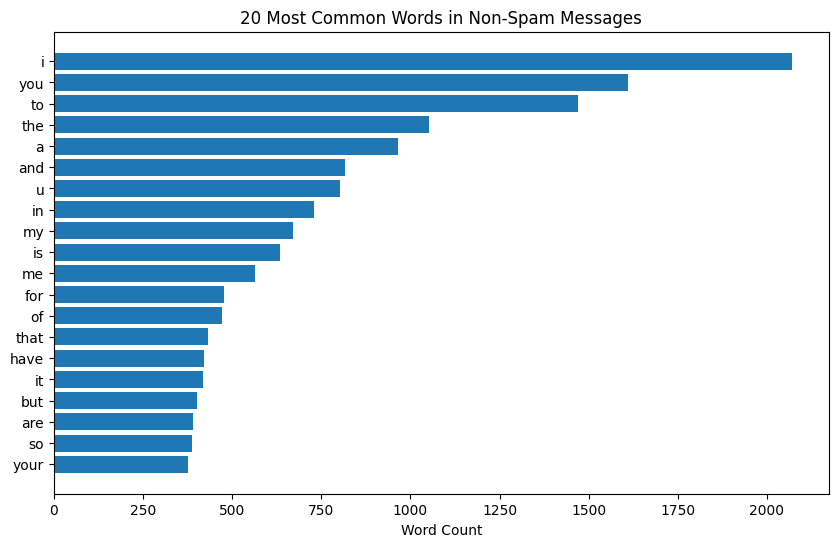

In [27]:
nonspam_messages = df[df['Category'] == 0]['Message']
nonspam_words = Counter([word for message in nonspam_messages for word in message.lower().split()]).most_common(20)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(nonspam_words))
ax.barh(y_pos, [count for word, count in nonspam_words])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in nonspam_words])
ax.invert_yaxis()  # invert the y-axis to show most frequent words on top
ax.set_xlabel('Word Count')
ax.set_title('20 Most Common Words in Non-Spam Messages')
plt.show()

From the word cloud, there are many words that appear in both spam and non-spam messages. These words do not carry much meaning on their own and should be removed to reduce noise in the dataframe.

#### Top 20 Most Frequent Words (Stopwords Removed)

The most frequent words, excluding stopwords, in all messages.

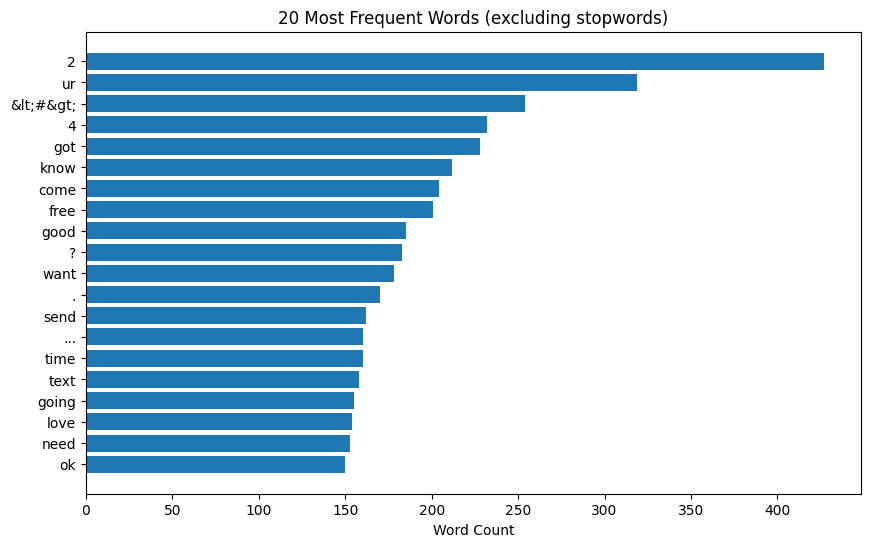

In [28]:
words = Counter([word for message in df['Message'] for word in message.lower().split() if word not in stopwords]).most_common(20)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(words))
ax.barh(y_pos, [count for word, count in words])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in words])
ax.invert_yaxis()  # invert the y-axis to show most frequent words on top
ax.set_xlabel('Word Count')
ax.set_title('20 Most Frequent Words (excluding stopwords)')
plt.show()

#### Word Cloud for Spam Messages (Stopwords Removed)

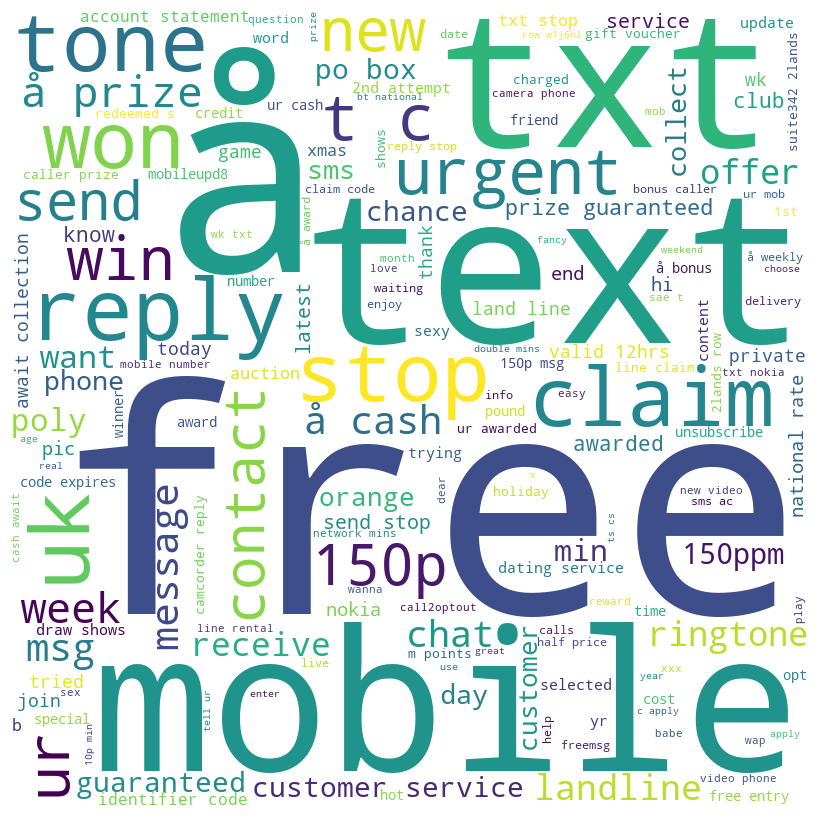

In [29]:
# Generate the word cloud
wordcloud = WordCloud(stopwords=stopwords, width=800, height=800, background_color='white', min_font_size=10).generate(spam_text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Bar graph for 20 most common words in Spam Messages (Stopwords Removed)

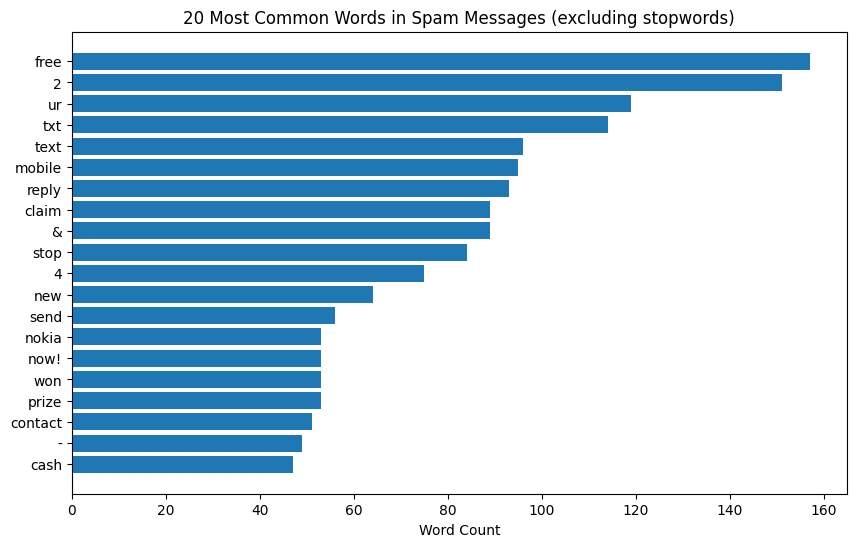

In [30]:
spam_messages = df[df['Category'] == 1]['Message']
spam_words = Counter([word for message in spam_messages for word in message.lower().split() if word not in stopwords]).most_common(20)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(spam_words))
ax.barh(y_pos, [count for word, count in spam_words])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in spam_words])
ax.invert_yaxis()  # invert the y-axis to show most frequent words on top
ax.set_xlabel('Word Count')
ax.set_title('20 Most Common Words in Spam Messages (excluding stopwords)')
plt.show()

#### Word Cloud for Non-Spam Messages (Stopwords Removed)

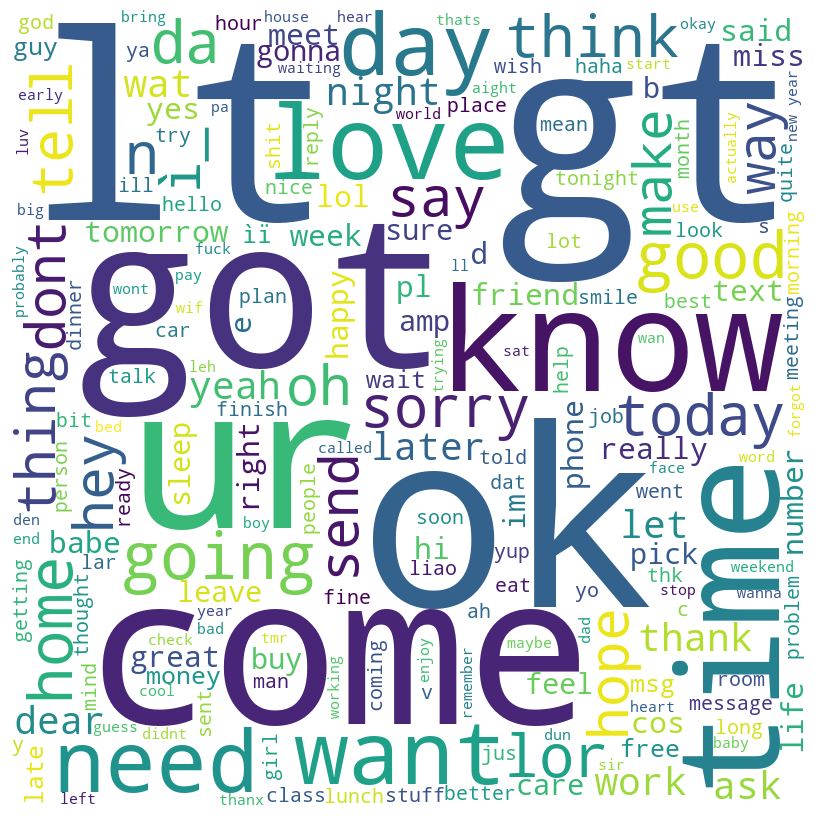

In [31]:
wordcloud = WordCloud(stopwords=stopwords,width=800, height=800, background_color='white', 
                      min_font_size=10).generate(nonspam_text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Bar graph for 20 most common words in Non-Spam Messages (Stopwords Removed)

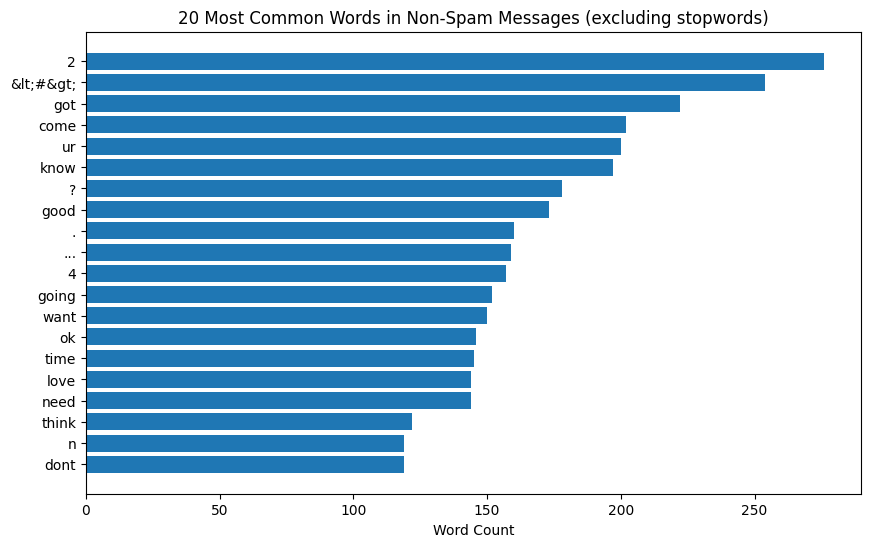

In [32]:
nonspam_messages = df[df['Category'] == 0]['Message']
nonspam_words = Counter([word for message in nonspam_messages for word in message.lower().split() if word not in stopwords]).most_common(20)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(nonspam_words))
ax.barh(y_pos, [count for word, count in nonspam_words])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in nonspam_words])
ax.invert_yaxis()  # invert the y-axis to show most frequent words on top
ax.set_xlabel('Word Count')
ax.set_title('20 Most Common Words in Non-Spam Messages (excluding stopwords)')
plt.show()

We can see that ham messages tend to contain more misspelled words and sequences of characters that don't make much sense, whereas spam messages contain more words that were spelled properly.

# Machine Learning

### Removing Stopwords
Removing Stopwords from all messages by creating a DataFrame containing all messages

In [33]:
#Splitting of main Dataframe into separate Dataframes
df_x = df[['Message', 'Contain_HP']]
df_y = df.Category

In [34]:
#Defining remove_stopwords function
def remove_stopwords(message):
    stop_words = set(stopwords)
    words = message.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [35]:
#Implementing remove_stopwords from df_x
for x in df_x.itertuples():
    df_x.at[x.Index, "Message"] = remove_stopwords(x.Message)

### Vectorizing strings to matrix

TfidVectorizer converts strings into a matrix of numbers that measure how relevant certain words are to a particular type of message, usually based on how often they appear. These values make it easier for machine learning algorithms to analyse the data and make predictions.

Here, we will split the dataset into test and train data, and begin running prediction models.

In [36]:
cv = TfidfVectorizer(min_df = 1, stop_words='english')

In [37]:
#Splitting the dataset into test and train data
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 42)
test_length = len(x_test)

In [38]:
x_traincv = cv.fit_transform(x_train.Message)
x_testcv = cv.transform(x_test.Message)

In [39]:
result = pd.DataFrame()
result['Model'] = None
result['Accuracy'] = None
result['F1_score'] = None

## Training with Naive Bayes

This is a classification algorithm based on weights assigned to individual words.

In [40]:
mnb_nb = MultinomialNB()
a_nb = x_traincv.toarray()
y_train = y_train.astype(int)
y_test = y_test.astype(int)
mnb_nb.fit(x_traincv, y_train)

MultinomialNB()

In [41]:
y_pred_nb = mnb_nb.predict(x_testcv)
actual_nb = np.array(y_test)

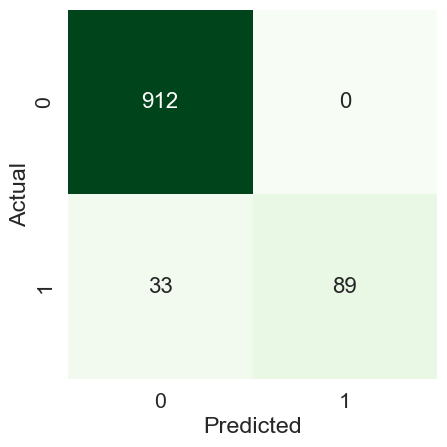

In [42]:
cm = confusion_matrix(actual_nb, y_pred_nb)
# Plot the confusion matrix using Seaborn
sns.set(font_scale=1.4) # Adjust the font scale for better visibility
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 16}, square=True)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [43]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_nb = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_nb)
print("F1 Score: ", f1_score(actual_nb, y_pred_nb))

True Positive Rate (TPR):  0.7295081967213115
True Negative Rate (TNR):  1.0
False Positive Rate (FPR):  0.0
False Negative Rate (FNR):  0.27049180327868855
Accuracy:  0.9680851063829787
F1 Score:  0.8436018957345972


In [44]:
result = pd.concat([result,pd.DataFrame({"Model": "Naive Bayes","Accuracy":acc_nb,'F1_score':f1_score(actual_nb, y_pred_nb)}, index=[0])]).reset_index(drop=True)

The Naive Bayes model is quite accurate as it has an accuracy score of 0.968 and a 1.0 true negative rate. However, the false negative rate is quite high which may be due to the imbalance of the dataset that was mentioned earlier. Since a majority of the messages were non-spam messages, many of the actual spam messages were predicted to be non-spam. Let's try out a few more models.

## Training with SVC

Support Vector Classification (SVC) is a prediction algorithm based on the features of the messages.

In [45]:
classifier_svc = SVC(random_state = 0)
classifier_svc.fit(x_traincv, y_train) ##using RBF kernel

SVC(random_state=0)

In [46]:
print(classifier_svc.score(x_testcv,y_test))

0.97678916827853


In [47]:
y_pred_svc = classifier_svc.predict(x_testcv)

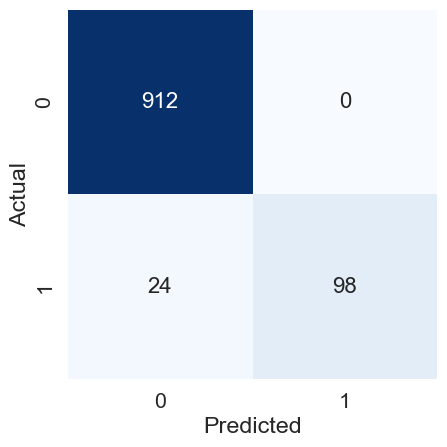

In [48]:
cm = confusion_matrix(y_test, y_pred_svc)
# Plot the confusion matrix using Seaborn
sns.set(font_scale=1.4) # Adjust the font scale for better visibility
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, square=True)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

#### Calculate Accuracies

In [49]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_svc = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_svc)
print("F1 Score: ", f1_score(y_test, y_pred_svc))

True Positive Rate (TPR):  0.8032786885245902
True Negative Rate (TNR):  1.0
False Positive Rate (FPR):  0.0
False Negative Rate (FNR):  0.19672131147540983
Accuracy:  0.97678916827853
F1 Score:  0.8909090909090909


In [50]:
result = pd.concat([result,pd.DataFrame({"Model": "SVC","Accuracy":acc_svc,'F1_score':f1_score(y_test, y_pred_svc)}, index=[0])]).reset_index(drop=True)

The SVC model is better than the Naive Bayes model as the false negative rate is lower and the true positive rate is higher. The true negative rate and the false positive rate are the same as Naive Bayes.

## Training with Random Forest Classifier

The Random Forest Classifier is a classification algorithm based on multiple decision trees.

In [51]:
classifier_rfc = RandomForestClassifier()
classifier_rfc.fit(x_traincv, y_train)
y_pred_rfc = classifier_rfc.predict(x_testcv)

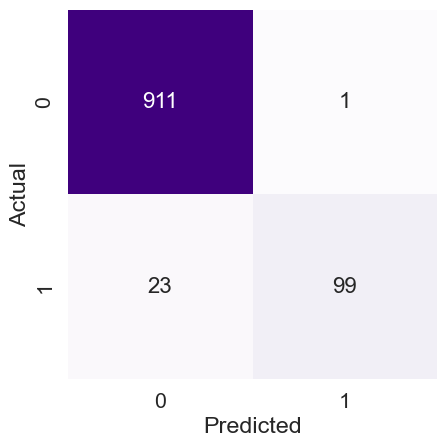

In [52]:
cm = confusion_matrix(y_test, y_pred_rfc)
sns.set(font_scale=1.4) # Adjust the font scale for better visibility
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False, annot_kws={"size": 16}, square=True)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

#### Calculate Accuracies

In [53]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_rfc = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_rfc)
print("F1 Score: ", f1_score(y_test, y_pred_rfc))

True Positive Rate (TPR):  0.8114754098360656
True Negative Rate (TNR):  0.9989035087719298
False Positive Rate (FPR):  0.0010964912280701754
False Negative Rate (FNR):  0.1885245901639344
Accuracy:  0.97678916827853
F1 Score:  0.8918918918918919


In [54]:
result = pd.concat([result,pd.DataFrame({"Model": "Random Forest Classifier","Accuracy":acc_rfc,'F1_score':f1_score(y_test, y_pred_rfc)}, index=[0])]).reset_index(drop=True)

Unlike the previous 2 models, the Random Forest Classifier has 1 false positive. Its false negative rate is lower than Naive Bayes but higher than SVC. This means that SVC is still the model with the highest accuracy.

## Training with Logistic Regression

Logistic Regression makes predictions based on both 'Messages' and 'Contains_HP'.

In [55]:
X_train_combined = pd.concat([pd.DataFrame(x_traincv.toarray()), x_train['Contain_HP'].reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(x_testcv.toarray()), x_test['Contain_HP'].reset_index(drop=True)], axis=1)

# fit the logistic regression model on the training data
lr = LogisticRegression()
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

lr.fit(X_train_combined, y_train)

# make predictions on the testing data
y_pred_lr = lr.predict(X_test_combined)


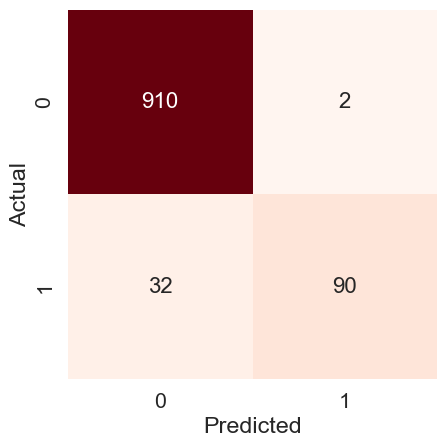

In [56]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.set(font_scale=1.4) # Adjust the font scale for better visibility
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', cbar=False, annot_kws={"size": 16}, square=True)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

#### Calculate Accuracies

In [57]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_lr = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_lr)
print("F1 Score: ", f1_score(y_test, y_pred_lr))

True Positive Rate (TPR):  0.7377049180327869
True Negative Rate (TNR):  0.9978070175438597
False Positive Rate (FPR):  0.0021929824561403508
False Negative Rate (FNR):  0.26229508196721313
Accuracy:  0.9671179883945842
F1 Score:  0.8411214953271028


In [58]:
result = pd.concat([result,pd.DataFrame({"Model": "Logistic Regression","Accuracy":acc_lr,'F1_score':f1_score(y_test, y_pred_lr)}, index=[0])]).reset_index(drop=True)

Logistic regression turns out to be the worst of all of the 4 models we have tried. It has the highest false positive rate and false negative rate.

## Model Ensemble

We will try to combine all the 4 models we have used - Naive Bayes, SVC, Random Forest Classifier, and Logistic Regression - into one model which should be more accurate than the individual models. The idea here is similar to a voting system - if a majority of the models predict a message to be spam, then the final prediction will be that it is a spam message. This would eliminate many of the false negatives that were present in the previous models.

After playing with the parameters, we found that having just 1 model to determine whether a message is spam provided the highest accuracy score.

In [59]:
ensemble = []
x_testlist = x_test.to_numpy()
for i in range(len(y_pred_lr)):
    if y_pred_lr[i] + y_pred_nb[i] + y_pred_rfc[i] + y_pred_svc[i] > 0:
        ensemble.append([1])
    else:
        ensemble.append([0])
ensemble_arr = np.array(ensemble)

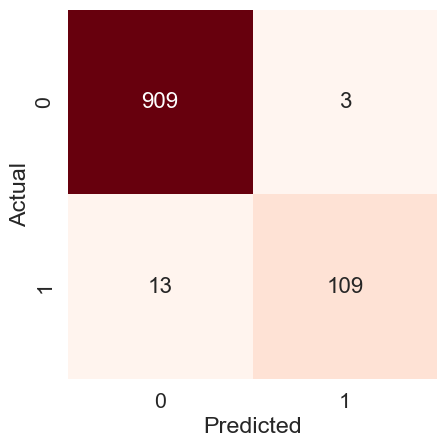

In [60]:
cm = confusion_matrix(y_test, ensemble_arr)
sns.set(font_scale=1.4) # Adjust the font scale for better visibility
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', cbar=False, annot_kws={"size": 16}, square=True)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

#### Calculate Accuracies

In [61]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_me = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_me)
print("F1 Score: ", f1_score(y_test, ensemble_arr))

True Positive Rate (TPR):  0.8934426229508197
True Negative Rate (TNR):  0.9967105263157895
False Positive Rate (FPR):  0.003289473684210526
False Negative Rate (FNR):  0.10655737704918032
Accuracy:  0.9845261121856866
F1 Score:  0.9316239316239318


In [62]:
result = pd.concat([result,pd.DataFrame({"Model":"Model Ensemble","Accuracy":acc_me,'F1_score':f1_score(y_test, ensemble_arr)}, index=[0])]).reset_index(drop=True)

As expected, the Model Ensemble is even more accurate than all the 4 models. Its false negative rate is much lower than SVC, and both the accuracy score and F1 score are the highest.

## K-Fold Cross-Validation

So far, the relative accuracies (from highest to lowest) of our models are:
1. Model Ensemble, Accuracy = 0.983
2. SVC, Accuracy = 0.977
3. Random Forest Classifier, Accuracy = 0.973
4. Naive Bayes, Accuracy = 0.968
5. Logistic Regression, Accuracy = 0.967

However, this may not represent the true accuracies and the true relative accuracies due to the imbalance in our dataset. Hence, we will carry out cross-validation of each prediction model and calculate the average accuracy score. We have determined that 5 folds give the highest accuracy.

In [63]:
num_folds = 5

from tqdm import tqdm

# define the k-fold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# create empty lists to store the accuracy scores for each model
nb_scores = []
svc_scores = []
rfc_scores = []
lr_scores = []
ensemble_scores = []

# iterate through each fold
for train_index, test_index in tqdm(kf.split(df_x)):
    # split the data into train and test sets
    x_train_kfold, x_test_kfold = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train_kfold, y_test_kfold = df_y.iloc[train_index], df_y.iloc[test_index]
    
    y_train_kfold = y_train_kfold.astype(int)
    y_test_kfold = y_test_kfold.astype(int)
    y_test_kfold = np.array(y_test_kfold)

    x_traincv_kfold = cv.fit_transform(x_train_kfold.Message)
    x_testcv_kfold = cv.transform(x_test_kfold.Message)
    X_train_combined_kfold = pd.concat([pd.DataFrame(x_traincv_kfold.toarray()), x_train_kfold['Contain_HP'].reset_index(drop=True)], axis=1)
    X_test_combined_kfold = pd.concat([pd.DataFrame(x_testcv_kfold.toarray()), x_test_kfold['Contain_HP'].reset_index(drop=True)], axis=1)
    X_train_combined_kfold.columns = X_train_combined_kfold.columns.astype(str)
    X_test_combined_kfold.columns = X_test_combined_kfold.columns.astype(str)


    # fit each model on the training data and make predictions on the test data
    mnb_nb_kfold = MultinomialNB()
    mnb_nb_kfold.fit(x_traincv_kfold, y_train_kfold)
    y_pred_nb_kfold = mnb_nb_kfold.predict(x_testcv_kfold)
    nb_scores.append(accuracy_score(y_test_kfold, y_pred_nb_kfold))
    
    svc_kfold = SVC(random_state = 0)
    svc_kfold.fit(x_traincv_kfold, y_train_kfold)
    y_pred_svc_kfold = svc_kfold.predict(x_testcv_kfold)
    svc_scores.append(accuracy_score(y_test_kfold, y_pred_svc_kfold))
    
    rfc_kfold = RandomForestClassifier()
    rfc_kfold.fit(x_traincv_kfold, y_train_kfold)
    y_pred_rfc_kfold = rfc_kfold.predict(x_testcv_kfold)
    rfc_scores.append(accuracy_score(y_test_kfold, y_pred_rfc_kfold))
    
    lr_kfold = LogisticRegression()
    lr_kfold.fit(X_train_combined_kfold, y_train_kfold)
    y_pred_lr_kfold = lr_kfold.predict(X_test_combined_kfold)
    lr_scores.append(accuracy_score(y_test_kfold, y_pred_lr_kfold))
    
    ensemble = []
    x_testlist = x_test.to_numpy()
    for i in range(len(y_pred_lr_kfold)):
        if y_pred_lr_kfold[i] + y_pred_nb_kfold[i] + y_pred_rfc_kfold[i] + y_pred_svc_kfold[i] > 0:
            ensemble.append([1])
        else:
            ensemble.append([0])
    ensemble_arr_kfold = np.array(ensemble)
    ensemble_scores.append(accuracy_score(y_test_kfold, ensemble_arr_kfold))
    

5it [00:24,  4.87s/it]


In [64]:
def average(item):
    return float(sum(item) / len(item))

In [65]:
print(average(ensemble_scores))

0.9847171016044983


In [66]:
k_fold_data = {'Model':['Naive Bayes', 'SVC', 'Random Forest Classifier','Logistic Regression', 'Model Ensemble'],'Accuracy':[acc_nb, acc_svc, acc_rfc, acc_lr, acc_me], 'K-Fold Accuracy':[average(nb_scores), average(svc_scores), average(rfc_scores), average(lr_scores), average(ensemble_scores)]}
k_fold_df = pd.DataFrame.from_dict(k_fold_data)
k_fold_df

,Model,Accuracy,K-Fold Accuracy
0,Naive Bayes,0.968085,0.965756
1,SVC,0.976789,0.976590
2,Random Forest Classifier,0.976789,0.974462
3,Logistic Regression,0.967118,0.962274
4,Model Ensemble,0.984526,0.984717


### K-Fold Accuracies

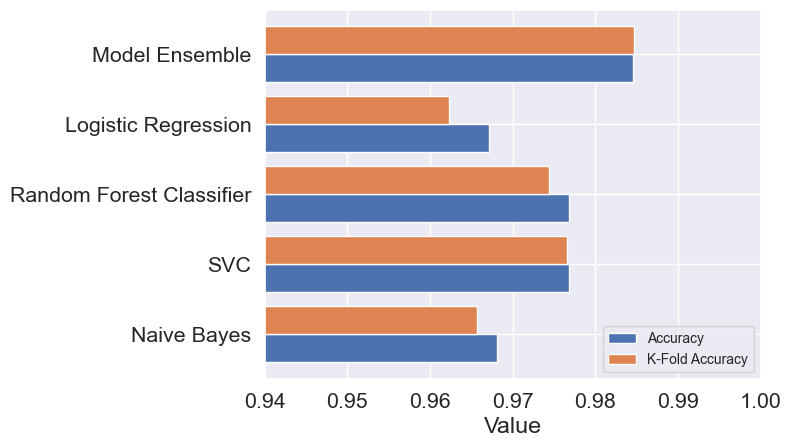

In [67]:
fig, ax = plt.subplots()

# set width of bars
bar_width = 0.4

# set positions of bars on x-axis
bar_pos1 = [0, 1, 2, 3, 4]
bar_pos2 = [x + bar_width for x in bar_pos1]

# create bars for Group 1
ax.barh(bar_pos1, k_fold_df['Accuracy'], height=bar_width, label='Accuracy')

# create bars for Group 2
ax.barh(bar_pos2, k_fold_df['K-Fold Accuracy'], height=bar_width, label='K-Fold Accuracy')

# set y-axis labels
ax.set_yticks([x + bar_width / 2 for x in bar_pos1])
ax.set_yticklabels(k_fold_df['Model'])

# set x-axis label and limits
ax.set_xlabel('Value')
ax.set_xlim([0.94, 1])

# add legend
ax.legend(fontsize = 10)

# show plot
plt.show()

The bar graph suggests that the models may have been overfitting the data when only run once. Other than Model Ensemble and Random Forest Classifier, the other models actually have lower accuracies after undergoing k-fold, with the biggest difference in Logistic Regression. This shows that simply running the prediction models once was not a good determinant of the actual accuracies. However, the relative accuracies of the models stayed the same.

## Analysis of Findings

From the confusion matrices and calculated accuracies of the 4 models (Ensemble is just a combination of them all so we ignore it here), there are significantly higher instances of False Negative than False Positive. Let's explore these False Negatives and see if they have anything in common.

In [68]:
false_neg_df = pd.DataFrame(columns=["Message"]) ## Create DataFrame to store all False Negative Results

y_test_copy = y_test
y_test_list = y_test_copy.to_numpy() ## Convert y_test to array for easier iteration

for i in range(len(y_pred_nb)): ## Adding of False Negative Messages from Naive Bayes model
    if y_pred_nb[i] == 0 and actual_nb[i] == 1:
        false_neg_df.loc[len(false_neg_df.index)] = [x_test.iloc[[i]].to_numpy()[0][0]] 


for i in range(len(y_pred_svc)): ## Adding of False Negative Messages from SVC model
    if y_pred_svc[i] == 0 and y_test_list[i] == 1:
        false_neg_df.loc[len(false_neg_df.index)] = [x_test.iloc[[i]].to_numpy()[0][0]] 

for i in range(len(y_pred_rfc)): ## Adding of False Negative Messages from Random Forest model
    if y_pred_rfc[i] == 0 and y_test_list[i] == 1:
        false_neg_df.loc[len(false_neg_df.index)] = [x_test.iloc[[i]].to_numpy()[0][0]] 

for i in range(len(y_pred_lr)): ## Adding of False Negative Messages from Logistic Regression model
    if y_pred_lr[i] == 0 and y_test_list[i] == 1:
        false_neg_df.loc[len(false_neg_df.index)] = [x_test.iloc[[i]].to_numpy()[0][0]] 

print(false_neg_df.shape)

(112, 1)


#### Analysis of all messages that appeared as False Negatives

In [69]:
removed_dup = false_neg_df.Message.unique()
print("Number of Unique Rows :", len(removed_dup))# Number of messages that are actually Spam but detected as Ham
print("Number of Duplicated Rows: ", len(false_neg_df) - len(removed_dup))

Number of Unique Rows : 49
Number of Duplicated Rows:  63


Most common words in false negatives:

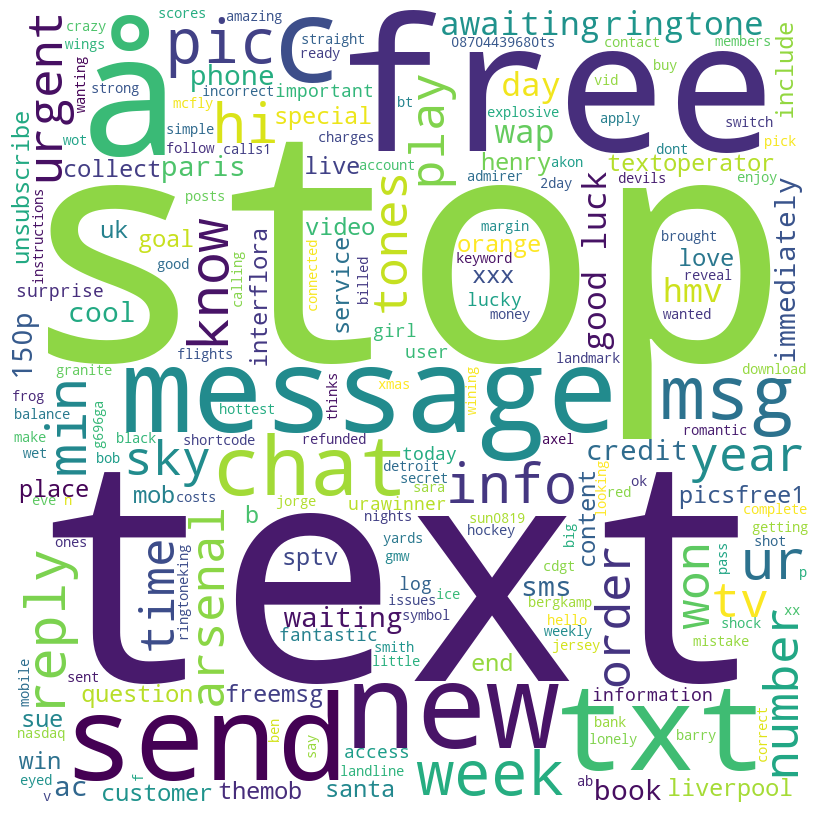

In [70]:
duplicate_list = []
for i in range(len(removed_dup)):
    split_list = (removed_dup[i].split())
    for word in split_list:
        duplicate_list.append(word)

duplicate_string = " ".join(duplicate_list).lower()
wordcloud = WordCloud(stopwords=stopwords,width=800, height=800, background_color='white', 
                      min_font_size=10).generate(duplicate_string)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Analysis of messages that appeared as False Negatives in more than 1 model

In [71]:
duplicated_df = false_neg_df[false_neg_df.Message.duplicated()].Message.unique()

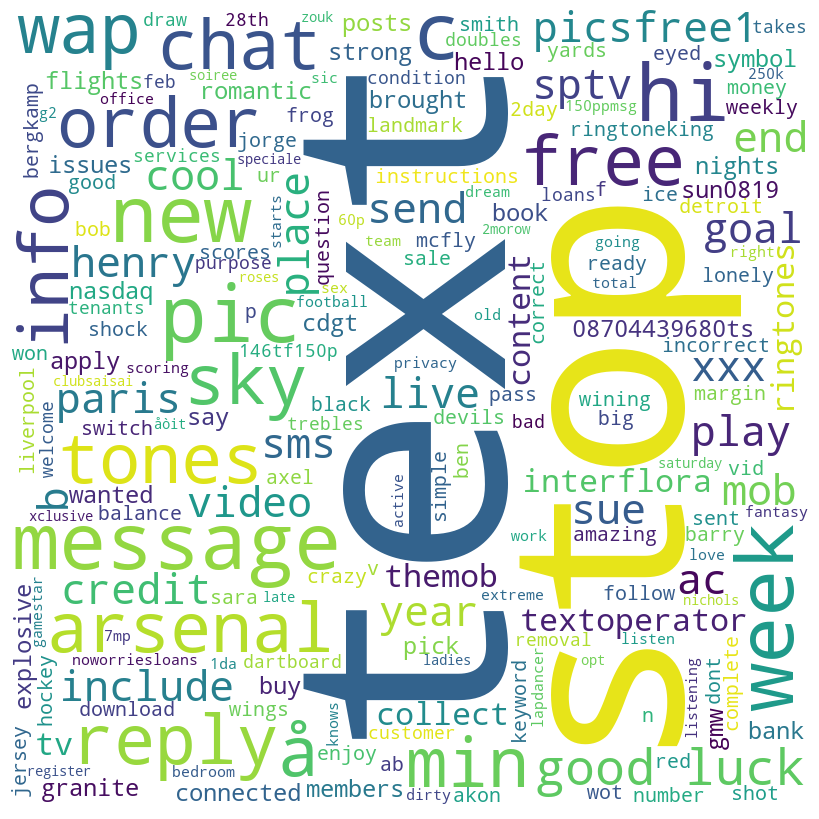

In [72]:
duplicate_list = []
for i in range(len(duplicated_df)):
    split_list = (duplicated_df[i].split())
    for word in split_list:
        duplicate_list.append(word)

duplicate_string = " ".join(duplicate_list).lower()
wordcloud = WordCloud(stopwords=stopwords,width=800, height=800, background_color='white', 
                      min_font_size=10).generate(duplicate_string)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [73]:
model_ensemble_df = pd.DataFrame(columns=["Message"]) ## Create DataFrame to store all False Negative Results

for i in range(len(ensemble_arr)):
    if ensemble_arr[i] == 0 and y_test_list[i] == 1:
        model_ensemble_df.loc[len(model_ensemble_df.index)] = [x_test.iloc[[i]].to_numpy()[0][0]]

Let's look at the content of all the messages that were false negatives.

In [74]:
for i in range(len(model_ensemble_df)):
    print(i + 1, ":",model_ensemble_df.Message[i])

1 : message brought GMW Ltd. connected
2 : SMS. ac sun0819 posts HELLO:\You cool wanted say hi. HI!!!\" Stop? Send STOP 62468"
3 : (Bank Granite issues Strong-Buy) EXPLOSIVE PICK MEMBERS *****UP 300% *********** Nasdaq Symbol CDGT $5.00 per..
4 : ringtoneking 84484
5 : Money won wining number 946 wot
6 : New Tones week include: 1)McFly-All Ab.., 2) Sara Jorge-Shock.. 3) Smith-Switch.. order follow instructions message
7 : Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry scores simple shot 6 yards pass Bergkamp Arsenal 2 goal margin 78 mins.
8 : amazing xxx PICSFREE1 video sent enjoy! vid 2day text keyword PICSFREE1 video.
9 : Ur balance å£600. question: Complete landmark, Big, A. Bob, B. Barry C. Ben ?. Text A, B C 83738. Good luck!
10 : sale - arsenal dartboard. Good condition doubles trebles!
11 : 2/2 146tf150p
12 : Hi sue. 20 years old work lapdancer. love sex. Text live - bedroom now. text SUE 89555. TextOperator G2 1DA 150ppmsg 18+
13 : Fantasy Football TV. Sky Gamestar Sky Active pl

What we can conclude here is that many of these messages contained misspellings and weird symbols which made them appear similar to ham messages. They also contained fewer spam-related words which caused the models to misclassify them as ham.

## Understanding Accuracies

Now, let's plot all of the accuracies of the 5 models on a graph to visualise our results.

### ROC Curve

<Figure size 640x480 with 0 Axes>

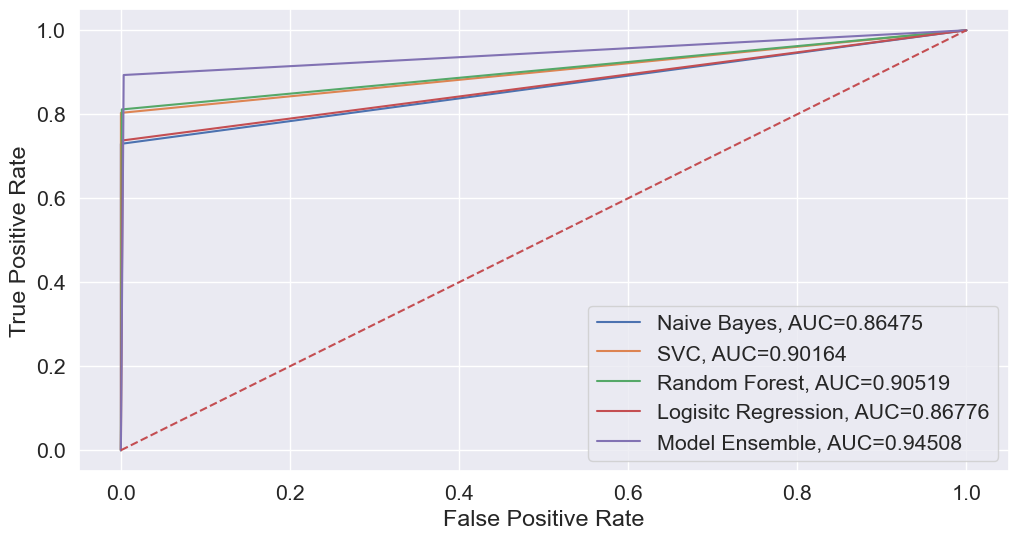

In [75]:
plt.figure(0).clf()
f = plt.figure(figsize=(12, 6))

#Naive Bayes
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_nb)
auc = round(metrics.roc_auc_score(y_test, y_pred_nb), 5)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#SVC
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_svc)
auc = round(metrics.roc_auc_score(y_test, y_pred_svc), 5)
plt.plot(fpr,tpr,label="SVC, AUC="+str(auc))

#Random Forest
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_rfc)
auc = round(metrics.roc_auc_score(y_test, y_pred_rfc), 5)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#Logisitc Regression
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_lr)
auc = round(metrics.roc_auc_score(y_test, y_pred_lr), 5)
plt.plot(fpr,tpr,label="Logisitc Regression, AUC="+str(auc))

#Logisitc Regression
fpr, tpr, _ = metrics.roc_curve(y_test, ensemble_arr)
auc = round(metrics.roc_auc_score(y_test, ensemble_arr), 5)
plt.plot(fpr,tpr,label="Model Ensemble, AUC="+str(auc))

plt.plot([0, 1], [0, 1],'r--')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

### Scatter Plot

In [76]:
print(result)

                      Model  Accuracy  F1_score
0               Naive Bayes  0.968085  0.843602
1                       SVC  0.976789  0.890909
2  Random Forest Classifier  0.976789  0.891892
3       Logistic Regression  0.967118  0.841121
4            Model Ensemble  0.984526  0.931624


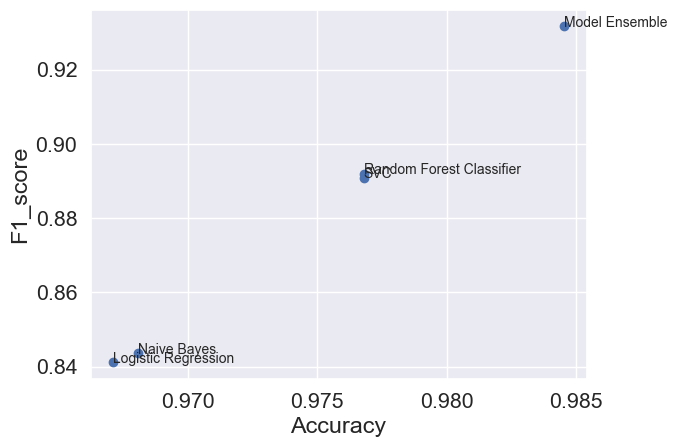

In [77]:
plt.scatter(result.Accuracy,result.F1_score)
plt.ylabel("F1_score")
plt.xlabel("Accuracy")
for i, row in result.iterrows():
    plt.annotate(row['Model'], (row['Accuracy'], row['F1_score']),fontsize=10)

plt.show()

# Final Thoughts

## Conclusion

The ROC curve and scatter plot show that Model Ensemble has the highest F1 and Accuracy score, and therefore the best classifier for ham and spam messages. So, we recommend using a combination of different classification models when it comes to filtering out spam.

## Future Improvements

- Training on a larger and more balanced dataset

- Incorporate deep neural networks machine learning techniques or natural language processing techniques

- Integrate user feedback loops to train model that learns from real-world user interaction

You can try out our Spam Buster 3000 below! It displays a GIF based on whether the message put in by the user is spam or not. Try typing in some actual ham and spam messages you have received :)

# Spam Buster 3000

In [78]:
f = Figlet(font = 'slant', justify="center")
print(colored(f.renderText("Spam Buster 3000")))

           _____                          ____             __           
          / ___/____  ____ _____ ___     / __ )__  _______/ /____  _____
          \__ \/ __ \/ __ `/ __ `__ \   / __  / / / / ___/ __/ _ \/ ___/
         ___/ / /_/ / /_/ / / / / / /  / /_/ / /_/ (__  ) /_/  __/ /    
        /____/ .___/\__,_/_/ /_/ /_/  /_____/\__,_/____/\__/\___/_/     
            /_/                                                         
                              _____ ____  ____  ____ 
                             |__  // __ \/ __ \/ __ \
                              /_ </ / / / / / / / / /
                            ___/ / /_/ / /_/ / /_/ / 
                           /____/\____/\____/\____/  
                                                     



In [79]:
x_input = cv.fit_transform(df_x.Message)

mnb_nb = MultinomialNB()
y_input = df_y.astype(int)

mnb_nb.fit(x_input, y_input)

classifier_svc = SVC(random_state = 0)
classifier_svc.fit(x_input, y_input) ##using RBF kernel

classifier_rfc = RandomForestClassifier()
classifier_rfc.fit(x_input, y_input)

x_input_combined = pd.concat([pd.DataFrame(x_input.toarray()), df_x['Contain_HP'].reset_index(drop=True)], axis=1)

# fit the logistic regression model on the training data
lr = LogisticRegression()
x_input_combined.columns = x_input_combined.columns.astype(str)
lr.fit(x_input_combined, y_input)

LogisticRegression()

### Try out Spam Buster 3000 below! Type in the message you received and let it decide if it is Spam!

#### Sample Spam: 

Best 0ffer L0AN
Personal & Business L0AN
Accept  Blacklist
N0 Hidden Fees
N0 Guarantor
Private & Confidential
https://wa.me/84164822

#### Sample Ham: 

Good Morning Janice! Excited to see you today!

In [80]:
message = input("SPAM BUSTER 3000 (enter 'quit' to exit):\t")
buster_dict = {"Message": [message]}
busterdf = pd.DataFrame.from_dict(buster_dict)
busterdf['Contain_HP'] = busterdf['Message'].apply(lambda x: bool(re.search(pattern, x)))
bustercv = cv.transform(busterdf.Message)
buster_combined = pd.concat([pd.DataFrame(bustercv.toarray()), busterdf['Contain_HP'].reset_index(drop=True)], axis=1)
buster_combined.columns = buster_combined.columns.astype(str)

buster_nb = mnb_nb.predict(bustercv)
buster_svc = classifier_svc.predict(bustercv)
buster_rfc = classifier_rfc.predict(bustercv)
buster_lr = lr.predict(buster_combined)
buster_score = buster_nb[0] + buster_svc[0] + buster_rfc[0] + buster_lr[0]
if buster_score > 0:
    ref = '<iframe src="https://giphy.com/embed/RI4LTRjrVJhTskGtrb" width="480" height="372" frameBorder="0" class="giphy-embed" allowFullScreen>'
else:
    ref = '<iframe src="https://giphy.com/embed/dnCNI8LEf7K4otcMqS" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen>'

HTML(ref)

SPAM BUSTER 3000 (enter 'quit' to exit):	spam
